In [1]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline
# %config InlineBackend.figure_formats = ['svg']
from qiskit import *

In [2]:
shots=1e3
g= 5
H = []

In [3]:
f = open("mitigated_g_5.txt",'r')
k=f.readlines()
theta_qc = []
H_qc = []
H_mitigated = []
for i in k:
    j = i[:-1].split(',' )
    theta_qc.append( float( j[0][1:]) )
    H_qc.append( float( j[1]))
    H_mitigated.append( float( j[2][:-1] ))

In [4]:
M = (0.5*g**2)*np.array([[0,0,0,0],[0,3,0,0],[0,0,3,0],[0,0,0,3]]) - (0.5/g**2)*np.array([[0,2,0,2],[2,0,0.5,0],[0,0.5,0,0.5],[2,0,0.5,0] ])
analytic_H = []
for i in theta_qc: 
    test_state = np.array([ [np.cos(i)],[np.sin(i)/np.sqrt(2)],[0],[np.sin(i)/np.sqrt(2)]  ])
    analytic_H.append( np.matmul( np.transpose(test_state)[0] , np.matmul( M ,test_state ))[0] )

In [5]:
minE = np.min( np.linalg.eig(M)[0] )

In [6]:
# IBMQ.save_account('8f371c4cd9299d2d47d8fb8921b3ac568ddd7ee69f1677c378224aa662e56d67b1753e0117ec71562b7da34ef2f73fd82b316664e2ab8fa8dc3827a626ebfe75')

In [7]:
# IBMQ.load_account()

In [8]:
def prob_1(block,qq,counts,shots):
    if block == 'ii':
        [i,j] = [2,3]
    elif block == 'ix':
        [i,j] = [0,1]
        
    P=0
    for k in list(counts.keys()): 
        pieces = []
        for n in range(len(k)):
            pieces.append(k[n])
        if str(pieces[i])+str(pieces[j]) == qq:
            P += counts[k]
    return P / shots

def prob_2(block,qq,counts,shots):
    if block == 'xx':
        [i,j] = [2,3]
    elif block == 'yy':
        [i,j] = [0,1]
        
    P=0
    for k in list(counts.keys()): 
        pieces = []
        for n in range(len(k)):
            pieces.append(k[n])
        if str(pieces[i])+str(pieces[j]) == qq:
            P += counts[k]
    return P / shots

In [9]:
def Hamiltonian(theta,counts_1,counts_2,shots=1024,g=1):
    P_00 = prob_1('ii','00',counts=counts_1,shots=shots) 
    
    Pix_00 = prob_1('ix','00',counts=counts_1,shots=shots)
    Pix_10 = prob_1('ix','10',counts=counts_1,shots=shots)
    
    Pzx_00 = prob_1('ix','00',counts=counts_1,shots=shots)
    Pzx_11 = prob_1('ix','11',counts=counts_1,shots=shots)

    
    Pxx_00 = prob_2('xx','00',counts=counts_2,shots=shots)
    Pxx_11 = prob_2('xx','11',counts=counts_2,shots=shots)

    Pyy_00 = prob_2('yy','00',counts=counts_2,shots=shots)
    Pyy_11 = prob_2('yy','11',counts=counts_2,shots=shots)

    #hamiltonian
    H_E = 3*(1 - P_00)
    H_B = (1/2)*( 5*(Pxx_00 + Pxx_11) + 5*(Pix_00 + Pix_10) + 3*(Pzx_00 + Pzx_11) - 3*(Pyy_00 + Pyy_11) -5)
    H = (g**2 /2)*H_E - (1/(2*g**2))*H_B
    return H 

In [10]:
for theta in theta_qc:
    qr_1 = QuantumRegister(4)
    cr_1 = ClassicalRegister(4)
    circuit_1 = QuantumCircuit(qr_1,cr_1)

    circuit_1.ry(2*theta,0)
    circuit_1.ch(0,1)

    circuit_1.ry(2*theta,2)
    circuit_1.ch(2,3)
    circuit_1.h(2)

    circuit_1.measure([0,1,2,3],[0,1,2,3])
    
    qr_2 = QuantumRegister(4)
    cr_2 = ClassicalRegister(4)
    circuit_2 = QuantumCircuit(qr_2,cr_2)

    circuit_2.ry(2*theta,0)
    circuit_2.ch(0,1)
    circuit_2.h(0)
    circuit_2.h(1)

    circuit_2.ry(2*theta,2)
    circuit_2.ch(2,3)
    circuit_2.rx(np.pi/2,2)
    circuit_2.rx(np.pi/2,3)

    circuit_2.measure([0,1,2,3],[0,1,2,3])
    QC_type = 1
    if QC_type == 0:
        provider = IBMQ.get_provider('ibm-q')
        backend = provider.get_backend('ibmq_16_melbourne') # Quantum Computer
    else: 
        backend = Aer.get_backend('qasm_simulator') # Quantum Simulator
    job_1 = execute(circuit_1, backend, shots=shots)
    job_2 = execute(circuit_2, backend, shots=shots)
    result_1 = job_1.result()
    result_2 = job_2.result()
    sim_counts_1 = result_1.get_counts(circuit_1)
    sim_counts_2 = result_2.get_counts(circuit_2)
        
    H.append(Hamiltonian(theta,counts_1=sim_counts_1,counts_2=sim_counts_2,shots=shots,g=g))

In [11]:
# %matplotlib inline

In [12]:
# circuit.draw(output='mpl')

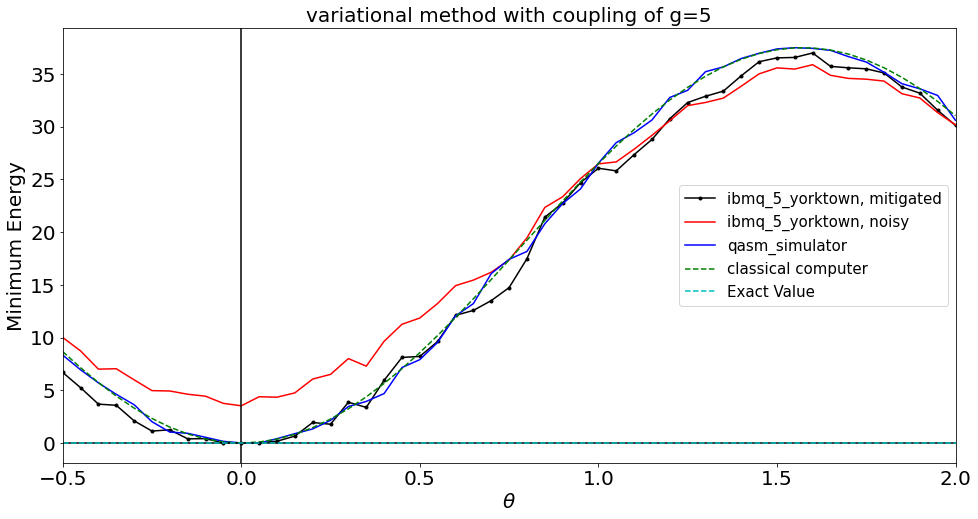

In [35]:
plt.figure(figsize=[16,8])
plt.plot(theta_qc,H_mitigated,'k.-',label='ibmq_5_yorktown, mitigated')
plt.plot(theta_qc,H_qc,'r-',label='ibmq_5_yorktown, noisy')
plt.plot(theta_qc,H,'b-',label='qasm_simulator')
plt.plot(theta_qc,analytic_H,'g--',label='classical computer',)
plt.axhline(0,color='k')
plt.axvline(0,color='k')
plt.xlim([-0.5,2.0])
plt.axhline(minE,color='c',ls='--',label='Exact Value')
plt.xlabel(r'$\theta$',fontsize=20)
plt.ylabel('Minimum Energy',fontsize=20)
plt.title('variational method with coupling of g=5',fontsize=20)
plt.legend(fontsize=15)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.savefig('mitigated_var_method.pdf')  
plt.show()

In [19]:
np.min(H_qc) , np.min(H_mitigated)

(3.525809999999999, 0.0010099256275433088)

In [15]:
theta_qc

[-0.5,
 -0.45,
 -0.4,
 -0.35,
 -0.3,
 -0.25,
 -0.2,
 -0.15,
 -0.1,
 -0.05,
 0.0,
 0.05,
 0.1,
 0.15,
 0.2,
 0.25,
 0.3,
 0.35,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6,
 0.65,
 0.7,
 0.75,
 0.8,
 0.85,
 0.9,
 0.95,
 1.0,
 1.05,
 1.1,
 1.15,
 1.2,
 1.25,
 1.3,
 1.35,
 1.4,
 1.45,
 1.5,
 1.55,
 1.6,
 1.65,
 1.7,
 1.75,
 1.8,
 1.85,
 1.9,
 1.95,
 2.0]